In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

ModuleNotFoundError: No module named 'matplotlib._api.deprecation'

In [1173]:
df = pd.read_csv('ev_charging_patterns.csv')
df.head(10)

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.000000,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.000000,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.000000,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.000000,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.000000,Level 1,Long-Distance Traveler
5,User_6,Nissan Leaf,50.000000,Station_335,San Francisco,2024-01-01 05:00:00,2024-01-01 07:10:00,43.181137,1.167640,14.334523,36.900341,Evening,Saturday,75.217748,71.982288,143.680046,-5.274218,0.000000,DC Fast Charger,Long-Distance Traveler
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,22.214225,Evening,Friday,60.751781,70.796097,81.338009,27.551335,4.000000,Level 2,Commuter
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,9.796821,Afternoon,Monday,56.201703,63.786815,116.543166,-4.417460,0.000000,Level 2,Long-Distance Traveler
8,User_9,Chevy Bolt,62.000000,Station_493,Los Angeles,2024-01-01 08:00:00,2024-01-01 09:21:00,43.592372,1.724204,14.294923,32.465005,Evening,Wednesday,33.466200,92.961421,208.259742,22.516706,4.000000,Level 1,Commuter
9,User_10,Hyundai Kona,50.000000,Station_452,Chicago,2024-01-01 09:00:00,2024-01-01 12:44:00,78.868607,2.026875,11.761000,21.312302,Morning,Wednesday,27.399455,70.053381,54.006309,27.512019,2.830381,DC Fast Charger,Commuter


In [1174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

In [1175]:
# 转换为时间变量
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'], errors='coerce')
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'], errors='coerce')

# 转化为类型变量减小内存占用(净整没用的
categorical_columns = ['User Type', 'Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']
for column in categorical_columns:
    df[column] = df[column].astype('category')


In [1176]:
# 删除含空值的行，重复行
df = df.dropna()
df = df.drop_duplicates()

# 把电越充越少坏东西的删掉
df = df.drop(df[df['State of Charge (End %)'] < df['State of Charge (Start %)']].index)
    
# 把充满了的删掉（因为会影响我们不知道他实际充电时间了（比划
df = df[df['State of Charge (End %)'] <= 99]


In [1177]:
# 构造新特征充电持续时间，不知道有啥用先搞了再说
df['Charging Duration_Cate'] = pd.cut(df['Charging Duration (hours)'],
                                          bins=[0, 1, 3, 6, np.inf],
                                          labels=['Short (<1 hr)', 'Medium (1-3 hrs)', 'Long (3-6 hrs)', 'Very Long (>6 hrs)'])

# Display count of different charging duration categories
print(df['Charging Duration_Cate'].value_counts())

df.info()

Medium (1-3 hrs)      488
Long (3-6 hrs)        246
Short (<1 hr)         115
Very Long (>6 hrs)      2
Name: Charging Duration_Cate, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 0 to 1317
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   851 non-null    object        
 1   Vehicle Model                             851 non-null    category      
 2   Battery Capacity (kWh)                    851 non-null    float64       
 3   Charging Station ID                       851 non-null    object        
 4   Charging Station Location                 851 non-null    category      
 5   Charging Start Time                       851 non-null    datetime64[ns]
 6   Charging End Time                         851 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                   

In [ ]:
# 用实际数据计算出实际的充电效率Charging Efficiency，啊这个啊很重要很重要要考的啊
df['Charging Efficiency'] = (((df['State of Charge (End %)'] - df['State of Charge (Start %)']) / 100) * df['Battery Capacity (kWh)']) / df['Charging Duration (hours)']

# 与原表中的理论值Charging Rate (kW)作比较
df['Loss'] = df['Charging Rate (kW)'] - df['Charging Efficiency']


In [1179]:
# Remove obvious outliers in Charging Efficiency 去除极端的异常值
q1 = df['Charging Efficiency'].quantile(0.25)
q3 = df['Charging Efficiency'].quantile(0.75)
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)
df = df[(df['Charging Efficiency'] >= lower_bound) & (df['Charging Efficiency'] <= upper_bound)]

# 把右侧Charging Rate太大的删掉
df = df[df['Charging Rate (kW)'] <= df['Charging Rate (kW)'].quantile(0.95)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 1 to 1317
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   760 non-null    object        
 1   Vehicle Model                             760 non-null    category      
 2   Battery Capacity (kWh)                    760 non-null    float64       
 3   Charging Station ID                       760 non-null    object        
 4   Charging Station Location                 760 non-null    category      
 5   Charging Start Time                       760 non-null    datetime64[ns]
 6   Charging End Time                         760 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                     760 non-null    float64       
 8   Charging Duration (hours)                 760 non-null    float64       
 9   Charging Rate (kW)             

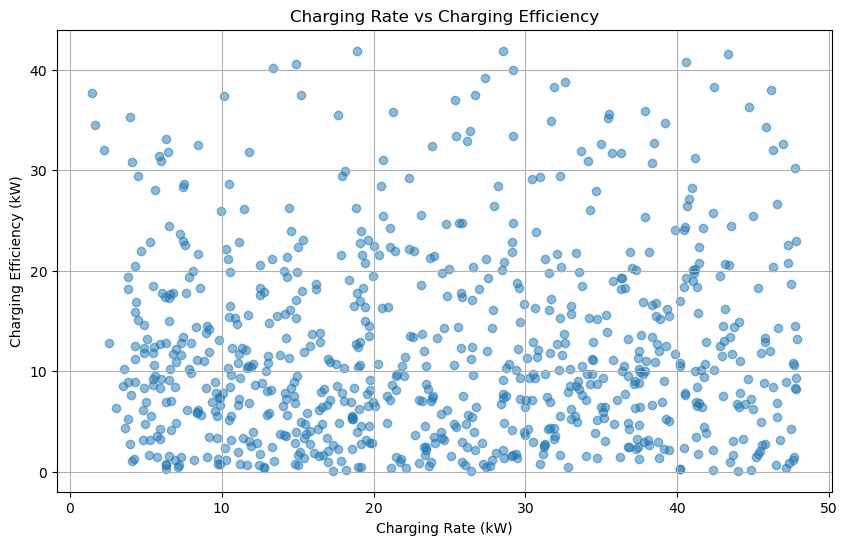

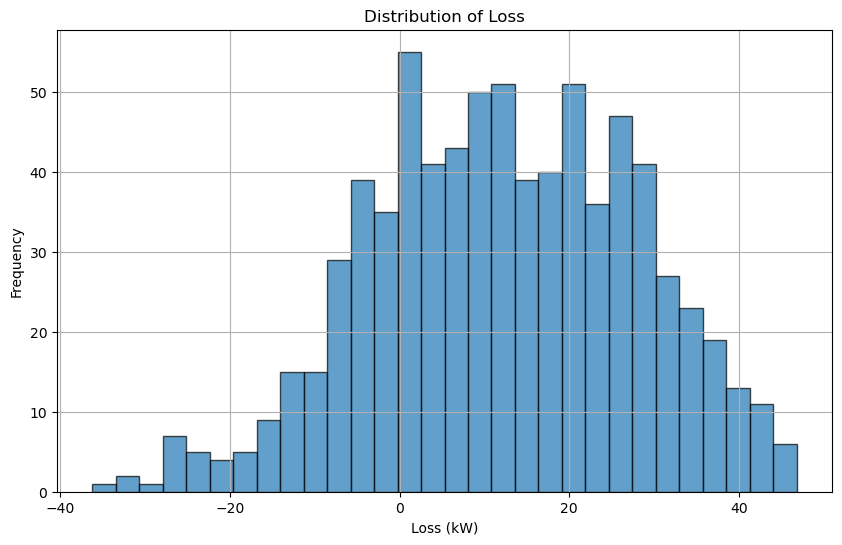

In [1180]:
# Visualize Charging Rate vs Charging Efficiency 这个是他们俩的分布散点图
plt.figure(figsize=(10, 6))
plt.scatter(df['Charging Rate (kW)'], df['Charging Efficiency'], alpha=0.5)
plt.xlabel('Charging Rate (kW)')
plt.ylabel('Charging Efficiency (kW)')
plt.title('Charging Rate vs Charging Efficiency')
plt.grid(True)
plt.show()

# Visualize the distribution of Loss 画出loss图（loss是用充电功率-实际充进去的功率算的反正也不知道有没有道理 画了再说
plt.figure(figsize=(10, 6))
plt.hist(df['Loss'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Loss (kW)')
plt.ylabel('Frequency')
plt.title('Distribution of Loss')
plt.grid(True)
plt.show()

                                          Charging Duration (hours)  \
Charging Duration (hours)                                  1.000000   
State of Charge (Start %)                                 -0.112585   
State of Charge (End %)                                    0.062586   
Distance Driven (since last charge) (km)                   0.047838   
Temperature (°C)                                          -0.058010   
Vehicle Age (years)                                        0.082724   
Charging Efficiency                                       -0.443656   
Loss                                                       0.257720   

                                          State of Charge (Start %)  \
Charging Duration (hours)                                 -0.112585   
State of Charge (Start %)                                  1.000000   
State of Charge (End %)                                    0.324551   
Distance Driven (since last charge) (km)                  -0.028899   
Tempe

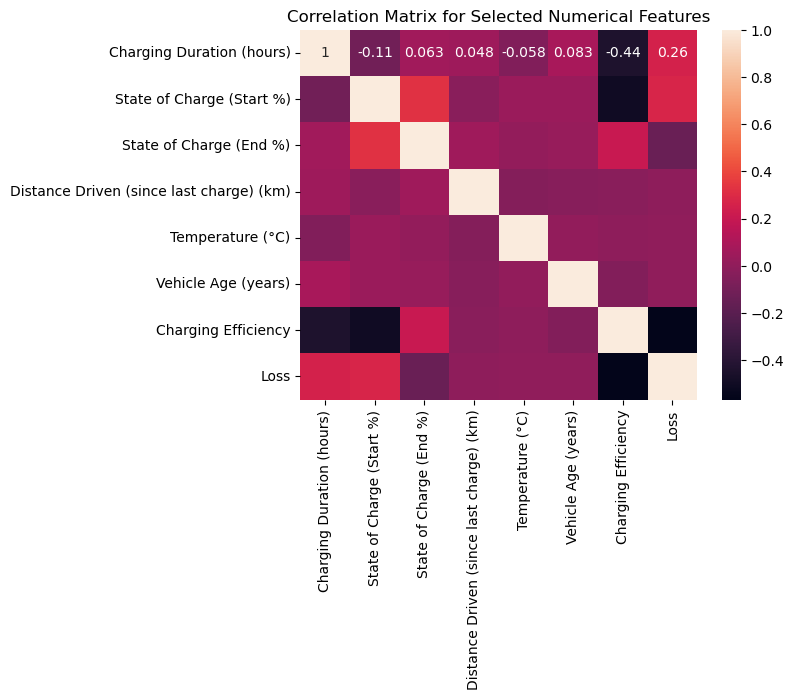

In [1181]:
# 画相关性矩阵，不知道有啥用但他们都画
plt.figure()
matrix = df.drop(columns=['Battery Capacity (kWh)', 'Energy Consumed (kWh)', 'Charging Rate (kW)', 'Charging Cost (USD)']).corr(method='pearson')
print(matrix)
sns.heatmap(matrix, annot=True)
plt.title('Correlation Matrix for Selected Numerical Features')
plt.show()


In [ ]:
# 预处理就到这了，下面都是在乱搞

In [1189]:
# 整体分析
features = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
y_efficiency = df['Charging Efficiency']
X = df[features]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_efficiency, test_size=0.2, random_state=0)



In [1192]:
# Linear Regression for Charging Efficiency 针对每小时充电效率的线性回归
from sklearn.model_selection import GridSearchCV
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

print(r2_score(y_test, y_pred_lin))

# Random Forest Regression for Charging Efficiency 针对每小时充电效率的随机森林回归
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print(r2_score(y_test, y_pred_rf))

0.6709825775938596
0.7922228139073508


In [ ]:
# 我现在想的是目标变量：Charging Efficiency，特征：'Charging Duration (hours)', 'Time of Day'， 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)'
# 先对所有数据整体分析，然后对分类对不同的Vehicle Model，User Type进行分类分析，比较类别之间的差异